In [3]:
"""
Train a diffusion model on images.
"""

import torch

from utils.pianoroll import load_data
from improved_diffusion.script_util import get_config, create_model, create_gaussian_diffusion


config, config_override = get_config('config/16bar_v_scratch_lm.yaml') # read config yaml at --config

model = create_model(config)
diffusion = create_gaussian_diffusion(config)

model.load_state_dict(
    torch.load('log/ema_0.9999_2750000.pt')
)

model.to('cuda')
model.eval()
encoder = model['encoder'] if 'encoder' in model else None
eps_model = model['eps_model']


In [73]:
rel_bias = sum(list(eps_model.transformer[i].temporal_attn.fn.relpb.parameters())[0] for i in range(4))/4

In [49]:
eps_model.transformer[2].temporal_attn.fn.relpb.num_buckets

32

<BarContainer object of 19 artists>

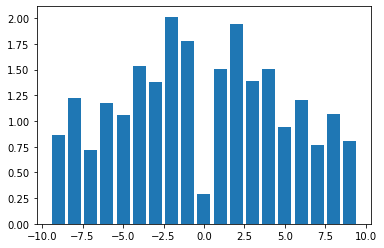

In [96]:
import matplotlib.pyplot as plt
import numpy as np
data = rel_bias.detach().cpu().mean(1).exp().numpy().tolist()
data = np.array(list(reversed(data[17:26]))+data[:10])
#data /= np.exp(-(0.08*np.array(list(range(-9,10))))**2)
plt.bar(list(range(-9,10)),data)


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (10,) and arg 1 with shape (9,).

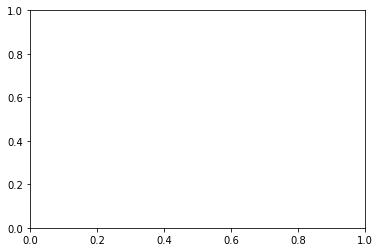

In [80]:
plt.bar(list(range(10)),data[17:26])

In [29]:
import math
def _relative_position_bucket(relative_position, num_buckets = 32, max_distance = 128):
    ret = 0
    n = -relative_position

    num_buckets //= 2
    ret += (n < 0).long() * num_buckets
    n = torch.abs(n)

    max_exact = num_buckets // 2
    is_small = n < max_exact

    val_if_large = max_exact + (
        torch.log(n.float() / max_exact) / math.log(max_distance / max_exact) * (num_buckets - max_exact)
    ).long()
    val_if_large = torch.min(val_if_large, torch.full_like(val_if_large, num_buckets - 1))

    ret += torch.where(is_small, n, val_if_large)
    return ret

In [46]:
import torch
from einops import rearrange
pos = torch.arange(-16, 16)
_relative_position_bucket(pos, num_buckets = 32, max_distance = 32)


tensor([12, 11, 11, 10, 10,  9,  9,  8,  8,  7,  6,  5,  4,  3,  2,  1,  0, 17,
        18, 19, 20, 21, 22, 23, 24, 24, 25, 25, 26, 26, 27, 27])

In [85]:
n=16
q_pos = torch.arange(n, dtype = torch.long)
k_pos = torch.arange(n, dtype = torch.long)
rel_pos = rearrange(k_pos, 'j -> 1 j') - rearrange(q_pos, 'i -> i 1')
_relative_position_bucket(rel_pos, num_buckets = 32, max_distance = 16)


tensor([[ 0, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31],
        [ 1,  0, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30],
        [ 2,  1,  0, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
        [ 3,  2,  1,  0, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28],
        [ 4,  3,  2,  1,  0, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27],
        [ 5,  4,  3,  2,  1,  0, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26],
        [ 6,  5,  4,  3,  2,  1,  0, 17, 18, 19, 20, 21, 22, 23, 24, 25],
        [ 7,  6,  5,  4,  3,  2,  1,  0, 17, 18, 19, 20, 21, 22, 23, 24],
        [ 8,  7,  6,  5,  4,  3,  2,  1,  0, 17, 18, 19, 20, 21, 22, 23],
        [ 9,  8,  7,  6,  5,  4,  3,  2,  1,  0, 17, 18, 19, 20, 21, 22],
        [10,  9,  8,  7,  6,  5,  4,  3,  2,  1,  0, 17, 18, 19, 20, 21],
        [11, 10,  9,  8,  7,  6,  5,  4,  3,  2,  1,  0, 17, 18, 19, 20],
        [12, 11, 10,  9,  8,  7,  6,  5,  4,  3,  2,  1,  0, 17, 18, 19],
        [13, 12, 11, 10,  9,  8,  7,  

In [34]:
rel_pos

tensor([[  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
          14,  15],
        [ -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
          13,  14],
        [ -2,  -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
          12,  13],
        [ -3,  -2,  -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
          11,  12],
        [ -4,  -3,  -2,  -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
          10,  11],
        [ -5,  -4,  -3,  -2,  -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,
           9,  10],
        [ -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,   3,   4,   5,   6,   7,
           8,   9],
        [ -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,   3,   4,   5,   6,
           7,   8],
        [ -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,   3,   4,   5,
           6,   7],
        [ -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,   3,   4,
           5,   6],
        [-